# MPC Additional Resources: Forecasting

This page presents different methodologies for prediction of returns that can be used by the MeanVariance MPC.

In order to keep the [introduction to the MeanVariance MPC framework](https://github.com/JuDO-dev/AirBorne.jl/blob/dev/docs/example_notebooks/MPC_Example.ipynb) short, the introduction to forecasting models has been presented here. 

1. Last Value
2. Linear Regression
3. Behavioural Forecast
4. Hidden Markov Model

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(["Dates","Plots","DataFrames", "DirectSearch","DotMaps","LinearAlgebra","Polynomials","SparseArrays","MathOptInterface","HiddenMarkovModels","Distributions"]);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Suppressor ─ v0.2.4
    Updating `~/.julia/environments/v1.8/Project.toml`
  [fd094767] + Suppressor v0.2.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [fd094767] + Suppressor v0.2.4
Precompiling project...
  ✓ Suppressor
  1 dependency successfully precompiled in 37 seconds. 216 already precompiled.


## DataSet
This dataset is formed by the top 5 most traded companies according to NASDAQ in each sector as per 3rd August 2023, listed since 2016 from Jan 1st 2017 until Jan 1st 2022.

In [ ]:
using DataFrames: groupby, combine
########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)
@info "Done!"
first(data,4)

In [2]:
# If you already have the data somewhere accessible by the cache loading the data directly is faster
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
data=load_bundle(bundle_id;cache_dir=cache_dir)
using AirBorne.ETL.AssetValuation: stockValuation, returns
dollar_symbol = "FEX/USD"
account_currency = dollar_symbol
sv=stockValuation(data)
sv[!,dollar_symbol].=1.0
sr=returns(sv)
@info "DataGenerated"

[ Info: DataGenerated


## Methods

### Perfect forecast

We refer to **Perfect Forecasting** to the return of the actual data. If there is a method that were capable of predicting exactly the evolution of the return it would be called the perfect forecast. 

In this forecast the variance is considered to be 0, as the knowledge of the precise behaviour of the return is known in advance, a perfect forecast does not have a sense of volatility on its predictions. An empirical sense of covariance can be drawn ex post the prediction but does not a emerge from a probabilistic nature of the forecast itself. 



In [12]:
using AirBorne.Structures: ContextTypeA  # Define context
using DataFrames: DataFrame

function perfectForecastReturns(context::ContextTypeA,returnData::DataFrame)
    n_assets = length(context.extra.symbolOrder)
    horizon=context.parameters.horizon
    r_mat=float.(Matrix(first(sr[sr.date.>context.current_event.date,context.extra.symbolOrder],horizon)))
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end

perfectForecastReturns (generic function with 1 method)

In [16]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC

pf_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

pf_params = Dict(
    "horizon"=>7,
)
pf_extras = Dict(
    "symbolOrder"=>["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"],
)
MPC.initialize!(pf_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=pf_extras,parameters=pf_params)
# Note: Once initialized context.symbolOrder looks like: ["NYQ/SPR", "NMS/TSLA", "NMS/AMZN", account_currency] 

perfectForecastFun(context) = perfectForecastReturns(context,sr)
perfectForecastFun(pf_context)

7-element Vector{Tuple{Vector{Float64}, Matrix{Float64}}}:
 ([0.01948416371919179, 0.028518175015711245, 0.027150610354876845, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.004037725968178341, 0.029633258297920753, -0.012139034655920934, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.0025676005595439188, 0.019254637045135074, 0.014885573930506536, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([0.015851589717382656, 0.03880052465815389, 0.0020916204156393933, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.013603684006325336, 0.04920482578812169, -0.007808640261289332, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.015819337255656412, -0.021945011900097317, 0.004799174786468337, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.042450940079958234, -0.0066272976331742195, -0.009410596802


### Last Value
The last value forecast assumes that in the future the value doesn't change, therefore whatever was the last return will also be in the future.

This approach is the one used by the Markowitz Strategy were the investement is done by measuring the expected return over a certain number days in the past and one assumes that in the future the expected return and the covariance between the returns of the asset will remain approximately the same. 


In [19]:
function LV_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    elementWise = get(context.extra,"elementWise",true)
    varianceWindowSize  = get(context.parameters, "varianceWindowSize", 7)
    expectedReturnWindowSize  = get(context.parameters, "expectedReturnWindowSize", 7)
    pastHorizon = get(context.parameters,"pastHorizon", 7)
    futureHorizon = get(context.parameters,"futureHorizon", 5)
    # size(rMat,1)-pastHorizon+1-varianceWindowSize
    minDataPoints =  max(expectedReturnWindowSize,varianceWindowSize)+1
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    # On an update this can be made more efficient by only calculating the latest value
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μ = mean(rMat[end-expectedReturnWindowSize+1:end,:];dims=1)
    if varianceWindowSize>1
        Σ = cov(rMat[end-varianceWindowSize+1:end,:])
    else
        Σ = zeros(size(rMat,2),size(rMat,2))
    end
    return [(μ,Σ) for i=1:futureHorizon] 
end

LV_Forecast (generic function with 1 method)

In [24]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC
lv_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

lv_params = Dict(
    "futureHorizon"=>1,
    "varianceWindowSize"=>20, # Number of datapoints to use to calculated expected (use 0 to not estimate variance)
    "expectedReturnWindowSize"=>20, # Number of datapoints to estimate expected returns (use 1 to use the last value and not an expectation)
)
lv_extras = Dict(
    "symbolOrder"=>["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"],
)

MPC.initialize!(lv_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=lv_extras,parameters=lv_params)
lv_context.extra.returnHistory = first(sr,21) # Data to be fed at first (for test purposes)

LV_Forecast(lv_context) 

1-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([-0.0023538027780066724 0.007062436275320651 0.005027746495853143 0.0], [0.0013546638965999842 0.0001870921771759758 -0.00031947204059482807 0.0; 0.0001870921771759758 6.211357854335754e-5 -4.395697395241245e-5 0.0; -0.00031947204059482807 -4.395697395241245e-5 7.560821580210154e-5 0.0; 0.0 0.0 0.0 0.0])


### Linear regression

**Linear Regression** fits a line through a number of past datapoints, the linear regression can be applied to:
1. The return vector as a whole (or each element of the return vector separately)
1. Each element of the covariance matrix


In [17]:
using AirBorne.ETL.AssetValuation: covariance
using Statistics: cov,mean
using JuMP: @variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using Ipopt: Ipopt

function LR_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    elementWise = get(context.extra,"elementWise",true)
    varianceWindowSize  = get(context.parameters, "varianceWindowSize", 7)
    expectedReturnWindowSize  = get(context.parameters, "expectedReturnWindowSize", 7)
    pastHorizon = get(context.parameters,"pastHorizon", 7)
    futureHorizon = get(context.parameters,"futureHorizon", 5)
    
    minDataPoints =  pastHorizon+max(expectedReturnWindowSize,varianceWindowSize)
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μMat = zeros(futureHorizon,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)
    for i= size(rMat,1)-pastHorizon+1:size(rMat,1) 
        ix= i-(size(rMat,1)-pastHorizon) 
      μMat[ix,:] = mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1)
      ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:])
    end
    
    # Pre-allocate Forecast Matrices
    μFMat = zeros(futureHorizon,size(rMat,2))
    ΣFMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)

    if elementWise # Forecast each entry of μ & Σ using normal linear regression
        aμ= zeros(size(μMat[1,:]))
        bμ= zeros(size(μMat[1,:]))
        aΣ= zeros(size(ΣMat[:,:,1]))
        bΣ= zeros(size(ΣMat[:,:,1]))
        X = hcat(ones(pastHorizon,1), 1:pastHorizon)
        XX=((X'*X)^-1)
        for i=1:length(aμ)
            bμ[i],aμ[i] = XX * (X' * μMat[:,i])
            for j=1:i # Leverage Symmetry
               bΣ[j,i],aΣ[j,i] = bΣ[i,j],aΣ[i,j] =  XX * (X' * ΣMat[i,j,:])
            end
        end
    else # Forecast μ & Σ as points of a high dimensional space
        μmodel = Model(Ipopt.Optimizer)
        μShape=size(μMat[1,:])[1]
        @variable(μmodel, a[1:μShape[1]])
        @variable(μmodel, b[1:μShape[1]])
        @objective(μmodel,Min,sum([sum(x.^2) for x in [a*i+b-μMat[i,:] for i=1:pastHorizon]]))
        optimize!(μmodel)
        aμ = deepcopy(value.(a)) 
        bμ = deepcopy(value.(b)) 
        Σmodel = Model(Ipopt.Optimizer)
        ΣShape=size(ΣMat[:,:,1])
        @variable(Σmodel, a[1:ΣShape[1],1:ΣShape[2]]) 
        @variable(Σmodel, b[1:ΣShape[1],1:ΣShape[2]])# I could add constraint of symmetry & diagonal being strictly positive
        @objective(Σmodel,Min,sum([sum(x.^2) for x in [a*i+b-ΣMat[:,:,i] for i=1:pastHorizon]]))
        optimize!(Σmodel)
        aΣ = deepcopy(value.(a)) 
        bΣ = deepcopy(value.(b)) 
    end

    μf(i) = aμ.*i + bμ
    Σf(i) = aΣ.*i + bΣ
    out=[]
    for i = 1:futureHorizon
        μFMat[i,:] = μf(i+pastHorizon)'
        ΣFMat[:,:,i] = Σf(i+pastHorizon)
        push!(out,(μFMat[i,:],ΣFMat[:,:,i]))
    end
   return out 
end



LR_Forecast (generic function with 1 method)

In [18]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC
using Dates:DateTime

lr_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

lr_params = Dict(
    "futureHorizon"=>7, # How many future predictions to make
    "pastHorizon"=>7, # How many past samples to take
    "varianceWindowSize"=>7, # Spread of the covariance moving average measurement
    "expectedReturnWindowSize"=>1, # Spread of the covariance moving average measurement
)

lr_extras = Dict(
    "symbolOrder"=> ["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"]
)

MPC.initialize!(lr_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=lr_extras,parameters=lr_params)
lr_context.extra.returnHistory = first(sr,14) # Data to be fed at first (for test purposes)

LR_Forecast(lr_context)

7-element Vector{Any}:
 ([0.009566263825567887, 0.014744185136356995, 0.0006894765029014944, 0.0], [0.0006180203437277521 0.0002818905296865593 4.6540077681892547e-5 0.0; 0.0002818905296865593 0.00022485396907219912 4.68220737516061e-5 0.0; 4.6540077681892547e-5 4.68220737516061e-5 4.8178511657771394e-5 0.0; 0.0 0.0 0.0 0.0])
 ([0.01305519410831451, 0.015524491285541588, 1.8235459586122757e-5, 0.0], [0.0006857077493204667 0.0003151808870165336 5.034906097339285e-5 0.0; 0.0003151808870165336 0.00022007781274946815 5.683730035539976e-5 0.0; 5.034906097339285e-5 5.683730035539976e-5 3.5374253397799695e-5 0.0; 0.0 0.0 0.0 0.0])
 ([0.016544124391061135, 0.01630479743472618, -0.0006530055837292497, 0.0], [0.0007533951549131813 0.0003484712443465079 5.415804426489315e-5 0.0; 0.0003484712443465079 0.00021530165642673718 6.685252695919343e-5 0.0; 5.415804426489315e-5 6.685252695919343e-5 2.2569995137827997e-5 0.0; 0.0 0.0 0.0 0.0])
 ([0.020033054673807754, 0.017085103583910775, -0.0013242466270

### Behavioural method

#### Single index trajectory forecast
Single index trajectories are the simplest to analyse and we shall use this section to introduce the **Behavioural model** for **Linear Time Invariant** (LTI) systems.

Recently a result from Behavioural systems known as the "fundamental lemma" implied that any trajectory of a LTI system can be described by a linear combination of previous trajectories of the same system.

Let's explain the above statement through an example. Let's say we have the value of a LTI system we want to predict, on time 1 it takes the value *h1*, at time 2 the value *h2* and so on. 

Now suppose that we define trajectories made by 3 consecutive values of this process and we want to predict the 3rd value of the current trajectory using the 2 last values. Moreover let us use the following definitions:

1. First trajectory from data **\[ *h1*, *h2*, *h3* ]**
1. Second trajectory from data **\[  *h2*, *h3*, *h4* ]**
1. Current trajecotry so far:  **\[  *h3*, *h4*, ? ]** 

With this information we can define what we call the **Hankel** matrix **H** shown below.

$$
H = \begin{bmatrix} 
    h_1 & h_2\\ 
    h_2 & h_3 \\ \hdashline 
    h_3 & h_4 \end{bmatrix} 
$$

Along with submatrices known as the *past Hankel* matrix Hp and the *future Hankel* matrix Hf.

$$H_p=\begin{bmatrix} h_1 & h_2\\h_2 & h_3 \end{bmatrix} $$
$$H_f\begin{bmatrix} h_3 & h_4 \end{bmatrix} $$

Then the problem becomes finding the coefficients of a linear combination **g** that matches our current data and using it to predict the next ones: 

$$
H_p*g=\begin{bmatrix} 
    h_1 & h_2\\ 
    h_2 & h_3 \end{bmatrix} * g = \begin{bmatrix}
    h_3\\ h_4 \end{bmatrix} 
$$

$$
g=H_p^{-1}\begin{bmatrix} h_3 \\ h_4 \end{bmatrix} 
$$
$$
\hat{h}_5=H_f*g = \begin{bmatrix} h_3 & h_4 \end{bmatrix}  *g
$$

#### Multi index trajectory forecast
So far the trajectory prediction relies on forming an invertible matrix for to match the past values and then taking the weigths on the future values to make the forecast. 


##### Option 1: Forecasting asset values separately
This requires the same amount of historical data, however there is no clear connection between the covariancce of the future trajectories. Lets examine Apple for example where the value of its shares is at time **i** is represented by **ai** 

$$
H = \begin{bmatrix}
    a_1 & a_2\\
    a_2 & a_3 \\  
    a_3 & a_4 \end{bmatrix} 
$$
$$
H_p*g=\begin{bmatrix} a_1 & a_2\\ a_2 & a_3 \end{bmatrix} * g = \begin{bmatrix} a_4 \\ a_5 \end{bmatrix} 
$$

$$
g=H_p^{-1}\begin{bmatrix} a_4 \\ a_5 \end{bmatrix} 
$$
$$
\hat{a}_5=H_f*g = \begin{bmatrix} a_3 & a_4 \end{bmatrix}  *g
$$

##### Option 2: Forecast asset value toghether
If one does it together on the other hand the amount of time samples to look into the past grows  significantly. Observe that the hankel matrix from stacking on top of each other A and B are is now of size 3*2 this means that the number of rows we will obtain is equal to  the full-horizon length times the number of assets being forecasted toghether.

$$
H_{1,2} = \begin{bmatrix} 
            a_1 & a_2\\
            a_2 & a_3\\
            a_3 & a_4\\
            b_1 & b_2\\
            b_2 & b_3\\
            b_3 & b_4\\ 
            \end{bmatrix} 
$$

Shuffling the rows around we cluster the past and future rows together by doing something like below. Where we can observe that the number of columns needed to obtain a past invertible matrix is equal to past-horizon times the number of assets forecasted togheter. 

> **Curse of dimensionality** Considering that there are more than 3000 assets retrievable by NASDAQ alone, just trying to forecast the next day by using 2 days in the past having full cross-correlation coverage implies having to use more than 10 years of past data, moreover consider that assets that were once correlated now may not be and assets now correlated may not have been before and not all assets existed 10 years ago, the problem becomes absurd from a contextual  point of view.

**Then the problem becomes:**
$$
H_{1,2} = \begin{bmatrix} 
            a_1 & a_2 & a_3 & a_4 \\
            b_1 & b_2 & b_3 & b_4 \\
            a_2 & a_3 & a_4 & a_5 \\
            b_2 & b_3 & b_4 & b_5 \\\hdashline 
            a_3 & a_4 & a_5 & a_6 \\ 
            b_3 & b_4 & b_5 & b_6 \\ 
            \end{bmatrix} 
$$

$$
H_p*g=\begin{bmatrix} 
            a_1 & a_2 & a_3 & a_4 \\
            b_1 & b_2 & b_3 & b_4 \\
            a_2 & a_3 & a_4 & a_5 \\
            b_2 & b_3 & b_4 & b_5 \\\end{bmatrix} * g = \begin{bmatrix} 
a_5 \\
b_5 \\
a_6 \\
b_6 \\ \end{bmatrix} 
$$

$$
\begin{bmatrix} \hat{a}_7 \\ \hat{b}_7 \end{bmatrix}=H_f*g = \begin{bmatrix}a_3 & a_4 & a_5 & a_6 \\ b_3 & b_4 & b_5 & b_6 \\  \end{bmatrix}  * g
$$

With this definition one can calculate the covariance of the trajectories using the traditional formula of the covariance.


In [157]:
using AirBorne.Structures: ContextTypeA
# First Look Among dynamic hyper-parameters, then look into static hyper-parameters
c_get(context,key,default) = get(context.parameters,key, get(context.extra,key, default))

function quickBehaviouralForecast(Y,y_ini)
   return  Y[length(y_ini)+1:end,:] * (Y[1:length(y_ini),:]\y_ini)
end

function behaviouralForecast(context::ContextTypeA)
    
    ########################
    ### Hyper-Parameters ###
    ########################
    elementWise = c_get(context,"elementWise",true)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    varianceWindowSize  = get(context.parameters, "varianceWindowSize", 0)
    expectedReturnWindowSize  = get(context.parameters, "expectedReturnWindowSize", 1)
    
    # The minimum data points in case of elementwise forecast is equal to the past horizon (I may exclude the currency as its value is always 1, thus its returns and variance always 0)
    trajetory_length = (pastHorizon + futureHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    n_columns_for_reversibility = (pastHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    N = trajetory_length + n_columns_for_reversibility # Number of datapoints in Hankel Matrix
    
    minDataPoints =  trajetory_length + n_columns_for_reversibility +  max(expectedReturnWindowSize,varianceWindowSize) # @info "minDataPoints" minDataPoints
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end

    ###############################
    ### Statistics Calculations ###
    ###############################
    
    # TODO: Implement incremental updates to Hankel Matrix to improve efficiency
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix
    if c_get(context,"excludeCurrencyFromCalculation", true)
        rMat = rMat[:,1:end-1] # Remove last column
    end
    
    μMat = zeros(N,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),N)
    for i= size(rMat,1)-N+1:size(rMat,1) 
        # @info i
        ix= i-(size(rMat,1)-N) 
        # @info ix
      μMat[ix,:] = expectedReturnWindowSize > 1 ? mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1) : rMat[i,:]
      if  varianceWindowSize > 1; ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:]); end
    end
    
    ###############################
    ### Behavioural Forecasting ###
    ###############################
    
    # Memory pre-allocation
    μFMat = zeros(futureHorizon,size(rMat,2)+1) # Forecast of expected return
    ΣFMat = zeros(size(rMat,2)+1,size(rMat,2)+1,futureHorizon) # Forecast of variance
    if elementWise
        # TODO: If happy with results do not store all the matrices, just re-write them to reduce memory allocation
        # The key on updating hankel matrices is to keep track of the oldest column and replace it with the new trajectory
        # The number of columns is n_columns_for_reversibility. So a counter with a modulus operator should suffice
        # There are extra nuances when considering the span of the trajectories.
        
        # Memory pre-allocation
        HΣi = zeros(trajetory_length,n_columns_for_reversibility) # Individual Covariance Hankel Matrix for asset pair
        Hμ = zeros(trajetory_length,n_columns_for_reversibility, size(rMat,2)) # Hankel Matrices for expected returns
        HΣ = Dict() # Hankel Matrices for covariance (since there is a lot of symmetry in this matrix, a hashmap is chosen as storage structure)
        
        μ_ini = μMat[end-pastHorizon+1:end,:] # Initial condition for expected returns
        Σ_ini = zeros(size(rMat,2),size(rMat,2),pastHorizon)
        
        for assetIx=1:size(rMat,2) # Iterate over each column (each asset)
            Hμ[:,:,assetIx]= cat([ μMat[end-i-trajetory_length+1:end-i] for i=1:n_columns_for_reversibility]...;dims=2)
            μFMat[:,assetIx]= quickBehaviouralForecast(Hμ[:,:,assetIx],μ_ini[:,assetIx])
            if varianceWindowSize>1 # Only go here if necessary
                for coAssetIx=1:assetIx # Build Hankel Matrix for Covariance
                    Σ_ini[assetIx,coAssetIx,:] = Σ_ini[coAssetIx,assetIx,:] = ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] 
                    HΣi[:,:] = cat([ ΣMat[assetIx, coAssetIx, end-i-trajetory_length+1:end-i]  for i=1:n_columns_for_reversibility]...;dims=2)
                    HΣ[(coAssetIx,assetIx)] = HΣ[(assetIx,coAssetIx)] = HΣi
                    ΣFMat[coAssetIx,assetIx,:] = ΣFMat[assetIx,coAssetIx,:] = quickBehaviouralForecast(HΣi,ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] )
                end
            end
         end
    else # Apply Behavioural forecast to all asset together, we need chunks 
        nAssets=size(rMat,2)
        μVec = reshape(μMat',1,:) # Restructured into: [a1,b1,c1,a2,b2,c2,...,aN,bN,cN] # Reshape μMat into 1D vector, easier to manipulate # @info "μMat" μMat μVec
        μ_ini = μVec[end-pastHorizon*nAssets+1:end]
        Hμ= cat(reverse([μVec[end-trajetory_length-nAssets*(i-1)+1:end-nAssets*(i-1)] for i=1:n_columns_for_reversibility])...;dims=2) # @info "Hμ" μ_ini Hμ 
        μF =  quickBehaviouralForecast(Hμ,μ_ini )
        μFMat[:,1:end-1] = vcat([μF[1+nAssets*(i-1):nAssets*i]' for i=1:futureHorizon]...)# @info "μF" μF μFMat
        
        # Comments on Covariance Forecasting
        # Trying to do the same thing with the covariance matrix makes the amount of data to grow quadratically with respect
        # to the number of symbols traded. (This is because the array will look like aa1,ab1,ac1,bb1,bc1,cc1,aa2,...,aaN,abN,...,ccN]
        # This is not practical unless for a small number of investment choices, therefore the Variance forecast will be set to 0
        # And the correlation between trajectories will be assumed to be assessed on the compound μ trajectory
        
    end
    return [(μFMat[i,:],ΣFMat[:,:,i]) for i=1:futureHorizon]
end

BehaviouralForecast (generic function with 1 method)

In [158]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC
b_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

b_params = Dict(
    "futureHorizon"=>5,
    "pastHorizon"=>4,
    
    "varianceWindowSize"=>3,
    "expectedReturnWindowSize"=>5,
    
    "elementWise"=>false, 
)
b_extras = Dict(
    "symbolOrder"=>["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"],
)

MPC.initialize!(b_context;currency_symbol=account_currency,min_data_samples=20,otherExtras=b_extras,parameters=b_params)
b_context.extra.returnHistory = first(sr,100) # Data to be fed at first (for test purposes)

BehaviouralForecast(b_context) 

┌ Info: minDataPoints
└   minDataPoints = 44


5-element Vector{Tuple{Vector{Float64}, Matrix{Float64}}}:
 ([-0.021485554689682707, -0.0032748777555403072, 0.01856092581889145, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([0.01844158385200624, -0.05818649387016962, 0.0013020575161824502, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.024052265317587647, -0.04089345751425147, 0.002011901434353737, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([-0.0009373376224481242, -0.03562122921606613, 0.025559807823324416, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])
 ([0.037452482441856984, 0.04189054112935138, 0.03174360647594799, 0.0], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])

### Hidden Markov Model (HMM)

In [7]:
using HiddenMarkovModels: HMM, transition_matrix, baum_welch, viterbi, obs_distribution, rand_trans_mat #, em
using Distributions: MvNormal
using LinearAlgebra: I

#######################
### Handy functions ###
#######################
function random_gaussian_hmm(N,dims)
       state_probability = ones(N) / N  # initial distribution (of the states)
       state_transition_matrix = rand_trans_mat(N)  # transition matrix (of the states)
       state_Covariance = Matrix(I, dims, dims).*1.0
       dists = [MvNormal(rand(dims),  state_Covariance) for n in 1:N]  # observation distributions (of the states)
       return HMM(state_probability, state_transition_matrix, dists)
end

function fitHMM(hmm_init,obs_seq)
    hmm_est, logL_evolution = baum_welch(hmm_init, obs_seq; rtol=-Inf, check_loglikelihood_increasing=false)
   return hmm_est
end

function gen_hmm(obs_seq::Vector{Vector{Float64}}; nHiddenStates::Int64=2, hmm_init=nothing)
       if isnothing(hmm_init)
           hmm_init=random_gaussian_hmm(nHiddenStates,length(obs_seq[1]))
       end
       return fitHMM(hmm_init,obs_seq)
end

matrix2seq(obs_seq) = [obs_seq[i,:] for i=1:size(obs_seq,1)]
get_current_state(hmm,obs_seq) = viterbi(hmm, obs_seq)[end]

######################
### HMM Forecaster ###
######################
using AirBorne.Structures: ContextTypeA

function hmmForecast(context::ContextTypeA)
    # If new data has come update observation sequence
    if  size(context.extra.returnHistory,1)>context.extra.lastScanIx
        @info "Adding new data"
        new_obs_seq = matrix2seq(float.(Matrix(
            context.extra.returnHistory[context.extra.lastScanIx:end,context.extra.symbolOrder]
        )))
        append!(context.extra.obs_seq,new_obs_seq)
        context.extra.lastScanIx = size(context.extra.returnHistory,1)
    end  
    if  mod(context.extra.lastScanIx, context.parameters.recalibrationPeriod)==0
        context.extra.hmm = gen_hmm(context.extra.obs_seq;hmm_init=context.extra.hmm)
    end
    hmm = context.extra.hmm; N=length(hmm);
    fitDists=[obs_distribution(hmm,i) for i=1:length(hmm)]
    μs= [f.μ for f=fitDists];    Σs=[f.Σ for f=fitDists]
    q0 = zeros(N);
    q0[get_current_state(hmm,context.extra.obs_seq)] = 1 # Probability of each state at t=0
    μ0 = sum(q0.*μs); Σ0 = sum([ q0[i].*Σs[i] for i=1:N])
    forecast = [] # I could initialize the array (Or make it part of the context, as the size is determined by futureHorizon and symbolOrder)mj
    
    for i=1:get(context.parameters,"futureHorizon",7)
        q1 = transition_matrix(hmm)*q0
        μ1 = sum(q1.*μs)
        Σ1 = sum([ q1[i].*(Σs[i] + ((μs[i]-μ1)*(μs[i]-μ1)'))  for i=1:N]) 
        q0,μ0,Σ0=q1,μ1,Σ1
            push!(forecast, (μ1,Σ1))
    end
    return forecast
end


hmmForecast (generic function with 1 method)

In [8]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
using Dates: DateTime

#############
### Usage ###
#############
traded_assets = ["NYQ/SPR", "NMS/TSLA", "NMS/AMZN"]
obs_seq = matrix2seq(float.(Matrix(sr[!,traded_assets])))
hmm = gen_hmm(obs_seq)

HMM_context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))

pf_params = Dict(
    "futureHorizon"=>7,
    "recalibrationPeriod"=>50, # Index to keep track of not yet ingested data.
)
pf_extras = Dict(
    "hmm"=>hmm, # Initial Hidden Markov Model
    "obs_seq"=>obs_seq, # Initial Warm-Start Data 
    "symbolOrder"=>traded_assets,
    "lastScanIx"=>0, # Index to keep track of not yet ingested data.
)

account_currency = "FEX/USD"
MPC.initialize!(
            HMM_context;
            currency_symbol=account_currency,
            min_data_samples=0,
            otherExtras=pf_extras,
            parameters=pf_params,
        )
hmmForecast(HMM_context)

7-element Vector{Any}:
 ([0.0007062507224677585, 0.002655424131399811, 0.0016905311662124753], [0.0008216140824952501 0.00020383680397072159 6.0076108272199256e-5; 0.00020383680397072159 0.0011012365397966468 0.00018954046478044756; 6.0076108272199256e-5 0.00018954046478044756 0.00026789202716493994])
 ([0.0005627965714500088, 0.003434970999984345, 0.0016491487991550787], [0.0012730910359189515 0.0003020474033952232 7.96169867755968e-5; 0.0003020474033952232 0.0014939867844180393 0.0002638860442664592; 7.96169867755968e-5 0.0002638860442664592 0.00035750384773232245])
 ([0.00045878151578872424, 0.004000201147394773, 0.0016191434686551743], [0.0016004101562797437 0.0003733730952750959 9.375742740784524e-5; 0.0003733730952750959 0.0017785564123219343 0.00031792271674521233; 9.375742740784524e-5 0.00031792271674521233 0.0004224658775456038])
 ([0.0003833627723960602, 0.004410035542755401, 0.001597387345880472], [0.0018377244523604605 0.0004251392776621729 0.00010399609175745475; 0.0004251

## Benchmarking
Now we shall compare the performance of each method by running a simulation over time of them using the AirBorne DEDS simulation engine with a customized trading logic method that solely performs the forecasting on each simulation event.

In [ ]:
function forcastTradingLogic!(context, data)
    #######################
    ####  Update data  ####
    #######################
    if size(data, 1) == 0 # No New data, nothing to do
        return nothing
    end
    context.extra.pastValue = context.extra.currentValue

    context.extra.currentValue = stockValuation(data)
    context.extra.currentValue[!, context.extra.currency_symbol] .= 1.0 # Add currency to values

    [push!(context.extra.valueHistory, r) for r in eachrow(context.extra.currentValue)]

    if size(context.extra.pastValue, 1) > 0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue, context.extra.currentValue))
        push!(context.extra.returnHistory, r1[end, :])
    end

    ###############
    ####  MPC  ####
    ###############

    if size(context.extra.returnHistory, 1) < context.extra.min_data_samples
        return nothing # Not enough history data to continue
    end

    # Forecasts
    meanVarianceForecast = forecastFun(context) # Returns a sequence of Return vectors and Covariance matrices
end


In [ ]:
using AirBorne.Structures: ContextTypeA, TimeEvent # Define context
import AirBorne.Strategies.MeanVarianceMPC as MPC

context = ContextTypeA(TimeEvent(DateTime("2020-01-01"),"start"))


params = Dict(
    "futureHorizon"=>7,
    "recalibrationPeriod"=>50, # Index to keep track of not yet ingested data.
)

extras = Dict(
    "hmm"=>hmm, # Initial Hidden Markov Model
    "obs_seq"=>obs_seq, # Initial Warm-Start Data 
    "symbolOrder"=>traded_assets,
    "lastScanIx"=>0, # Index to keep track of not yet ingested data.
    "forcastFunctions"=>Dict(
        "Perfect"=> perfectForecastFun,
        "LastValue"=> LV_Forecast,
        "LinearRegression"=> LR_Forecast,
        "Behavioural"=>behaviouralForecast,
        "HMM"=>hmmForecast,
        ), 
    "forecastResults"=>[], 
)

account_currency = "FEX/USD"

# The data goes from 2017 to 2022, we could use the returns of 2017 to warmstart the return history and the events 
# on +2018 to run the simulation

function my_initialize(context) 
    MPC.initialize!(
            context;
            currency_symbol=account_currency,
            min_data_samples=0,
            otherExtras=extras,
            parameters=params,
        )
    context.extra.returnHistory = first(sr,100) # Data to be fed at first (for test purposes)

end

### Performance analysis: Expected returns forecast  

**Note:** Expected returns in this example is defined for each asset as the percentual increment in the its close price with respect to the previous close price.

The forecasts in this example are functions of the form: 
$$R^{N_p \times n} \rightarrow R^{N_f \times n}$$

Given N_p datapoints from the past they produce the immediate N_f datapoints from the future, each datapoint consists of n elements, in the following examples each element correspond to the return of an asset. Therefore forecast matrix has one row per time, and one column per assetID.

In [159]:
using DataFrames: DataFrame
using Polynomials: fit

function genData(data::DataFrame,t;N_p::Union{Nothing,Int64}=nothing)
   return isnothing(N_p) ?  data[1:t,:] : data[t-N_p+1:t,:]      
end

function genActual(data::DataFrame,t,N_f)
    return data[t+1:t+N_f,:] 
end

function lastValForecast(data,N_f)
    forecast=DataFrame()
    last_val=data[end,:]
    [push!(forecast,last_val) for i=1:N_f]
    return forecast
end

function polyFitForecast(data,N_p,N_f;order::Int64=1)
    x = 1:N_p # Assume equidistant points
    xf = N_p+1: N_p+N_f
    out = DataFrame()
    for col=names(data) # For each column
        poly=fit(x,float.(data[end-N_p+1:end,col]),1)
        out[!,col]=poly.(xf)
    end
    return out
end

# Each stock is forecasted separatedly
function behaviouralForecast_A(data,N_p,N_f; calc_var::Bool=false)
    N=N_p+N_f
    Y= Matrix{Float64}(undef, N, N)
    out = DataFrame()
    
    for col=names(data) # For each column
        Y_all = float.(data[!,col])
        y_ini = Y_all[end-N_p+1:end] # Initial conditions to be matched
        for i=1:N
            Y[i,:]= Y_all[end-i-N+1:end-i] 
        end
        Yp = Y[1:N_p,:] # Past-matching segments
        Yf = Y[N_p+1:end,:] # Future-matching segments
        g = Yp\y_ini # Least square weigths estimation of past trajectory        
        out[!,col]=Yf*g # Composition leading to future trajectory
        if calc_var
        out[!,"VAR__" * col] = (((Yf .-out[!,col])*g).^2)./(length(g)-1) # Variance on prediction 
        end
    end
    return out
end

# Forecasts tests (Pass to Unit Tests)
t = 100
N_p = 30
N_f = 15
filtered_data = genData(rv_data,t;N_p=N_p)
filtered_data2 = genData(rv_data,t)
actual = genActual(rv_data,t,N_f)
forecast_lastVal = lastValForecast(filtered_data,N_f)
forecast_linReg = polyFitForecast(filtered_data,3,N_f)
forecast_behavioural = behaviouralForecast_A(filtered_data2,N_p,N_f;calc_var=true)
@info "Done"
# @info size(rv_data)
# @info size(filtered_data)
# @info size(actual)
# @info size(forecast_lastVal)
# @info size(forecast_behavioural)



[ Info: Done


#### Forecast performance tests

In [139]:
using Statistics: mean
"""
    Logarithmic Mean Squared Error

    Each row is a different data point.
    Each columns correspond to dimension of the datapoints.

    Calculates the squared error between the forecast and the actual accross all datapoints 
    and normalizes by dividing over the number of datapoints times the dimensions.

    Lastly applies Log10 to the result.
"""
function LMSE(actual::DataFrame,forecast::DataFrame)
    return  log(sum((Matrix(forecast) - Matrix(actual)).^2) / prod(size(Matrix(forecast))))
end

"
    Logarithmic squared error (LSE)

    Each row is a different data point.
    Each columns correspond to dimension of the datapoints.

    Calculates for each datapoint the Log10 of the squared error between the forecast and the actual.
"
function LSE(actual::DataFrame,forecast::DataFrame) 
   return log.(mean((Matrix(forecast) - Matrix(actual)).^2,dims=2))
end
@info "Done"



[ Info: Done


In [98]:
# Error Calculations
t = 100
N_p = 30
N_f = 15

LVF(data) = lastValForecast(data,N_f)
LRF(data) = polyFitForecast(data,N_p,N_f;order=1)
BHF(data) = behaviouralForecast_A(data,N_p,N_f; calc_var=false)
forecast_pairs= [("LV",LVF), ("LR",LRF),("BH",BHF)]

start_ix = findfirst(==(DateTime("2018-01-03T10:30:00")), rv.date)
end_ix = size(rv.date,1)-N_f
i = start_ix 

R_LSE=[]
R_LMSE=[]
for i=start_ix:end_ix #start_ix+2
    flush(stdout);print((i-start_ix)/(end_ix-start_ix));print("\r")
    source= genData(rv_data,i)
    actual = genActual(rv_data,i,N_f)
    i_forecasts = Dict([fp[1]=>fp[2](source) for fp in forecast_pairs])
    push!(R_LSE, Dict([key=>LSE(actual,value)' for (key, value) in i_forecasts]))
    push!(R_LMSE, Dict([key=>LMSE(actual,value) for (key, value) in i_forecasts]))
end


##### LMSE Analysis
The **LMSE** is the **L**og10 of the **Mean** **S**quared **E**rror of a forecast over the forecasted horizon.

It can be seen that "Linear Regression" (**LR**) is in general significatively more accurate than "Last Value"(**LV**) and "Behavioural"(**BH**) approaches, where **BH** is the worst performant.

However **LV** shows greater variance and higher extreme values than the other methods.

[ Info: Mean(LR-LMSE):-8.04264833274971
[ Info: Mean(BH-LMSE):-7.506721239167692
[ Info: Mean(LV-LMSE):-7.682152475652974


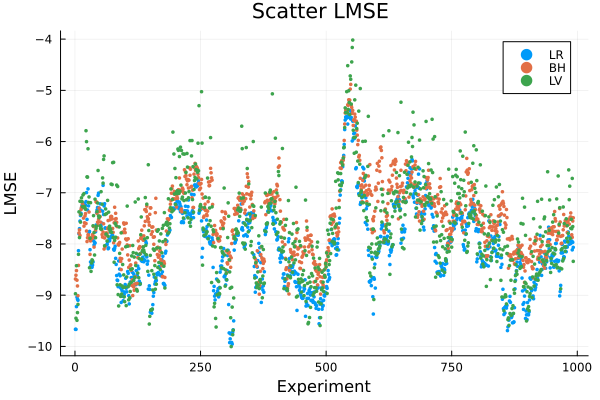

In [158]:
using Plots:  scatter
using Statistics: mean, median


df_LMSE=DataFrame(R_LMSE)
for key=names(df_LMSE)
@info "Mean($(key)-LMSE):$(mean(df_LMSE[!,key]))"
end
# LSE_Heatmaps = Dict([key=> countMatrix(reduce(vcat, df_LSE[!,key])) for key=names(df_LSE)])

# means_LSE=[mean(reduce(vcat, df_LSE[!,key]),dims=1) for key=names(df_LSE)]
scatter(1:size(df_LMSE,1),
    [df_LMSE[!,key] for key=names(df_LMSE)],label=reshape(names(df_LMSE),1,:),
    title="Scatter LMSE ", xlabel="Experiment", ylabel="LMSE", ms=2,msw=0 #,lw=0.01
    # markersize=0.5, color=[:red :green :blue],
)


##### LSE Analysis

The **LSE** is the **L**og10 of the **S**quared **E**rror of a forecast of a particular datapoint, the Mean LSE is the average LSE of all experiments at a over a particular distance in time into the future.  

It can be seen that "Linear Regression" (**LR**) is in general significatively more accurate than "Last Value"(**LV**) and "Behavioural"(**BH**) approaches, where **BH** is the worst performant. Moreover **LR** is the only forecast that consistently gets worse the furter into the future, albeit this trend is clear when observing the mean is not so when observing the distribution of the error.


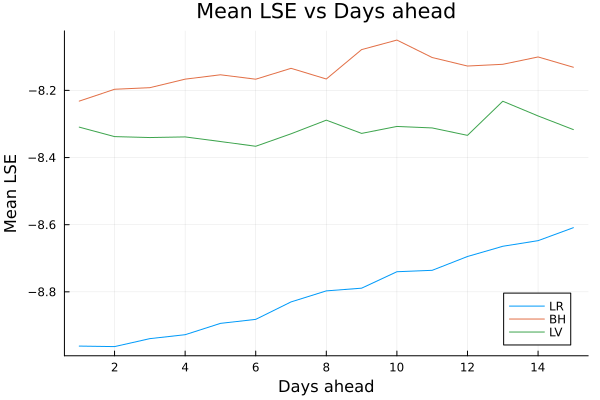

In [277]:
using Plots: heatmap, plot, plot!
using Statistics: mean, median
function countMatrix(res_Mx::Matrix;step::Real=0.5)
    m,_ = findmin(res_Mx)
    M,_ = findmax(res_Mx)
    thresholds = collect(floor(m):step:ceil(M))
    NumExperiments,MaxHorizon = size(Matrix(res_Mx))
    vizMat = zeros((length(thresholds),size(res_Mx,2)))
    for i = 2:length(thresholds)
        for col=1:size(res_Mx,2)
            c = sum((res_Mx[:,col].>=thresholds[i-1]) .&& (res_Mx[:,col].<thresholds[i])) 
            vizMat[i,col] = c / NumExperiments
        end     
    end
    return vizMat, thresholds
end

df_LSE=DataFrame(R_LSE)
LSE_Heatmaps = Dict([key=> countMatrix(reduce(vcat, df_LSE[!,key])) for key=names(df_LSE)])

means_LSE=[mean(reduce(vcat, df_LSE[!,key]),dims=1) for key=names(df_LSE)]
plot(1:15,
    [mean(reduce(vcat, df_LSE[!,key]),dims=1)[:] for key=names(df_LSE)],label=reshape(names(df_LSE),1,:),
    title="Mean LSE vs Days ahead", xlabel="Days ahead", ylabel="Mean LSE"
)


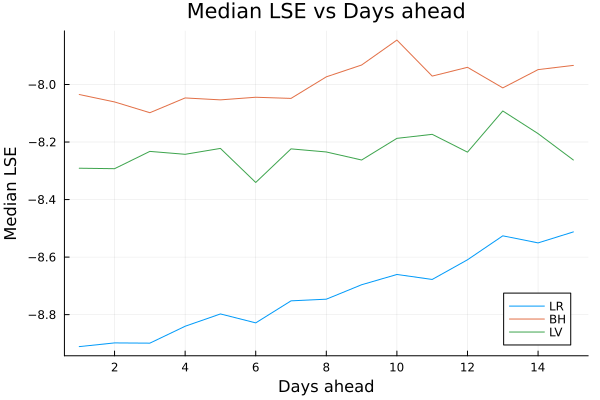

In [278]:
plot(1:15,
    [median(reduce(vcat, df_LSE[!,key]),dims=1)[:] for key=names(df_LSE)],label=reshape(names(df_LSE),1,:),
    title="Median LSE vs Days ahead", xlabel="Days ahead", ylabel="Median LSE"
)

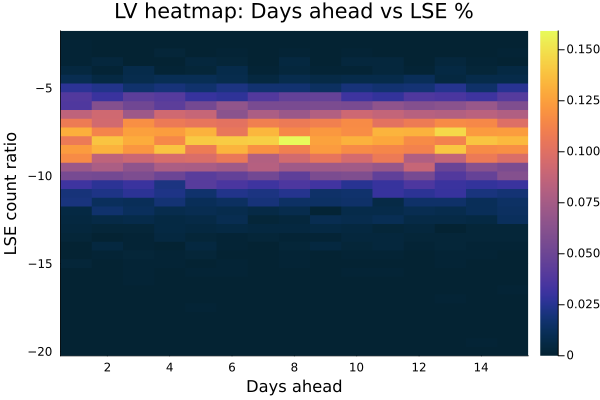

In [279]:
key = "LV"
vizMat = LSE_Heatmaps[key][1]
thresholds = LSE_Heatmaps[key][2]
heatmap(1:size(vizMat,2),thresholds, vizMat,c=:thermal, xlabel="Days ahead",
    ylabel="LSE count ratio",title="$(key) heatmap: Days ahead vs LSE %")

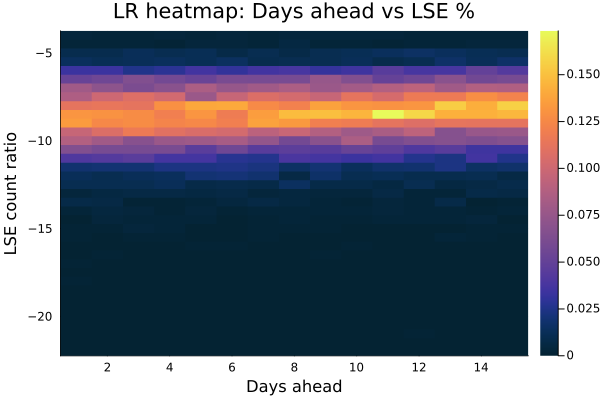

In [280]:
key = "LR"
vizMat = LSE_Heatmaps[key][1]
thresholds = LSE_Heatmaps[key][2]
heatmap(1:size(vizMat,2),thresholds, vizMat,c=:thermal, xlabel="Days ahead",
    ylabel="LSE count ratio",title="$(key) heatmap: Days ahead vs LSE %")

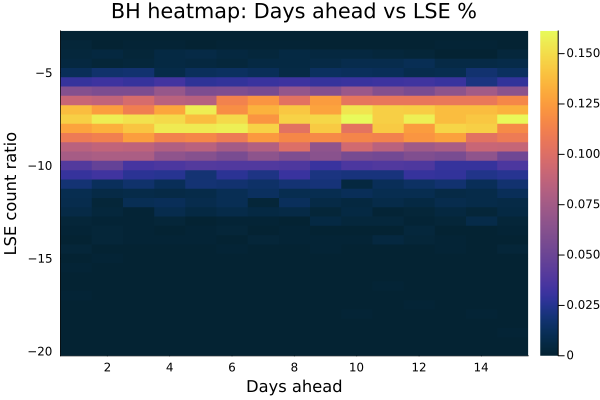

In [281]:
key = "BH"
vizMat = LSE_Heatmaps[key][1]
thresholds = LSE_Heatmaps[key][2]
heatmap(1:size(vizMat,2),thresholds, vizMat,c=:thermal, xlabel="Days ahead",
    ylabel="LSE count ratio",title="$(key) heatmap: Days ahead vs LSE %")

### Performance analysis: Covariance Matrix forecast  
In this case we will try to predict the overall movement of the covariance matrix. This is particularly hard to evaluate given the **covariance definition:**

$$ Cov(X,Y)=E[(X−EX)(Y−EY)] $$

This is because the covariance matrix is calculated for a sample of days, and defining a single covariance matrix for each day in a sequence is not well (or precisely) defined.

The main idea is that the behaviour of the value of different assets is linked over time and there exist a certain likelihood of when one goes up another may be more (or less) likely to also go up given that information, i.e., due to the underlying companies be geo-politically related or due to belonging to the same supply-chain link. What we want to predict is how this relationships naturally change as time passes, if they become stronger or weeker with the passage of time.

linearRegressionForecast (generic function with 1 method)

## Hyper-Parameter Tuning

Given a cost function it a procedure that modifies the parameters of the context can be put forward to gradually decrease the value of the cost function. These parameters could be the hyperparameters of the forecasting function, and the cost function could be:

1. The MSE (Mean Squared Error) of the forecast
1. The overall return at the end of a long period
